In [1]:
%load_ext autoreload
%autoreload 2

import sys 
import glob
import ray
import logging 
import gc
import cv2
import time
import itertools
import pickle
import pathlib 
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.stats import binned_statistic
from sklearn.model_selection import GroupShuffleSplit


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True

# sys.path.append(str(Path('.').absolute()))
from NLMixedUtils.utils import *
import NLMixedUtils.io_dict_to_hdf5 as ioh5
from NLMixedUtils.format_data import *
from NLMixedUtils.models import *
from NLMixedScripts.fit_GLM import *

device = torch.device("cuda:{}".format(get_freer_gpu()) if torch.cuda.is_available() else "cpu")

# pd.set_option('display.max_rows', None)
# %matplotlib widget
# ray.init(
#     ignore_reinit_error=True,
#     logging_level=logging.ERROR,
# )


In [10]:
NKfold = 1
test_train_size = .75
frac = .1
def get_train_test_split(data,NKfold=1,test_train_size=.75,frac=.1):
    gss = GroupShuffleSplit(n_splits=NKfold, train_size=test_train_size, random_state=42)
    nT = data.shape[0]
    groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])

    train_idx_list=[]
    test_idx_list = []
    for train_idx, test_idx in gss.split(np.arange(data.shape[0]), groups=groups):
        train_idx_list.append(train_idx)
        test_idx_list.append(test_idx)
    return train_idx_list, test_idx_list

In [3]:
#load npy file: "standard frames"
# import numpy as np

#Unpack dictionary into individual variables with same individual names as in previous session
from operator import itemgetter

def getList(dict):
    list = []
    for key in dict.keys():
        list.append(key)
          
    return list

npy_dict_name=input("Enter full path and filename of standard frames file to load")
npy_dict=np.load(npy_dict_name,allow_pickle='True')
npy_dict=npy_dict.item()

npy_dict_list=getList(npy_dict)
print(npy_dict_list)
print(len(npy_dict_list))

for i in range(0,len(npy_dict_list)):
    globals()[npy_dict_list[i]]=itemgetter(npy_dict_list[i])(npy_dict)

%whos

Enter full path and filename of standard frames file to load /mnt/c/Users/McCormick Lab/Documents/Python/uobrainflex/scripts/plots/3056_200924_E235_1_00003_00001/standard_frames_3056_200924_E235_1_00003_00001_20220510-133446.npy


['behav_resamp_frame', 'behav_corr_frame', 'dfof_upsamp_frame', 'bsoid_frame', 'roi_info_frame', 'areas', 'iscell', 'ops', 'behav_t', 'ppl_t', 'movie_t', 'meso_t', 'dfof_upsamp_frame.index', 'session_masks', 'iscell_masks', 'area_num', 'outlines_flat', 'nROIs', 'stat', 'fsuffix']
20
Variable                  Type                            Data/Info
-------------------------------------------------------------------
ActorHandle               type                            <class 'ray.actor.ActorHandle'>
Affine                    type                            <class 'kornia.geometry.t<...>ransform.affwarp.Affine'>
ComplexVisNetwork         type                            <class 'NLMixedUtils.models.ComplexVisNetwork'>
DataLoader                type                            <class 'torch.utils.data.dataloader.DataLoader'>
Dataset                   type                            <class 'torch.utils.data.dataset.Dataset'>
EarlyStopping             type                            <cla

In [63]:
behav_resamp_frame.head()

,lft_ppl_ser,rt_ppl_ser,lft_whisk_ser,rt_whisk_ser,walk_ser,fr_cl_2p_ser,p_diode_ser,piezo_co_ser,ni_pzo_ser
0.000000,0.273711,0.237261,0.041724,0.243140,3.010964,4.856720,0.000166,0.000305,-0.012207
0.099969,0.274084,0.226989,0.039892,0.187979,3.010913,4.852295,-0.000125,0.000458,-0.011749
0.199937,0.274491,0.216465,0.026297,0.014080,3.010887,-0.004883,-0.000139,-0.000153,-0.012360
0.299906,0.274851,0.205611,0.024303,0.015456,3.010912,4.860382,-0.000111,0.000610,-0.000763
0.399874,0.275454,0.204962,0.028182,0.017156,3.010954,4.858551,-0.000097,0.000305,-0.012207


In [64]:
xt = behav_resamp_frame.iloc[:,:5].to_numpy()

In [65]:
yt = dfof_upsamp_frame.to_numpy()

In [66]:
yt.shape,xt.shape

((54038, 5678), (54038, 5))

In [67]:
train_idx_list, test_idx_list = get_train_test_split(xt)

In [68]:
x_train = xt[train_idx_list[0]]
y_train = yt[train_idx_list[0]]
x_test = xt[test_idx_list[0]]
y_test = yt[test_idx_list[0]]

xtr = torch.from_numpy(x_train).float()
xte = torch.from_numpy(x_test).float()
ytr = torch.from_numpy(y_train).float()
yte = torch.from_numpy(y_test).float()


In [69]:
input_size = xt.shape[1] # number of inputs
output_size= yt.shape[1] # number of cells

In [70]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani']        = dates_all[0]
args['train_shifter']   = False
args['NoL1']            = True
args['NoL2']            = False
args['reg_lap']         = False
args['complex']         = False
args['do_shuffle']      = False
args['use_spdpup']      = True
args['Nepochs'] = 10000


params,file_dict,exp = load_params(MovModel,Kfold,args,{},debug=True)

params['lag_list']     = [0]
params['nt_glm_lag']   = len(params['lag_list'])



In [71]:
params['nks'] = np.shape(xt)[1:]
params['nk'] = params['nks'][0]*params['nt_glm_lag']
shift_in_tr = None
shift_in_te = None
xtrm = None
xtem = None

# Regularization parameters
params['move_features'] = None
params['alphas'] = np.array([.0001 if params['NoL1']==False else None])
if params['NoL2']:
    params['lambdas'] = np.array([0])
else:
    params['lambdas'] = np.hstack((np.logspace(-2, 3, 20)))
    params['nlam'] = len(params['lambdas'])
if params['reg_lap']:
    params['alpha_l'] = np.hstack((np.logspace(2, 8, 20,base=10)))
    params['nlam'] = len(params['alpha_l'])
else:
    params['alpha_l'] = np.array(params['nlam']*[None])
params['nalph'] = len(params['alphas'])
params['lambdas_m'] = np.array(params['nlam']*[None])
params['alphas_m'] = np.array(params['nalph']*[None])
params['lr_w'] = [1e-5, 1e-3]
params['lap_M'] = None
params['NoShifter']=True
params['lr_b'] = [1e-5, 5e-3]
params['lr_shift'] = [1e-3,1e-2]
params['Ncells'] = y_train.shape[-1]

In [72]:
meanbias = torch.mean(torch.from_numpy(y_train).float(), axis=0)

In [73]:
l1,optimizer,scheduler = get_model(input_size, output_size, meanbias, 1, device, 0, 0, params, NepochVis=10000)

In [74]:
out = l1(xtr, xtrm, shift_in_tr)
loss = l1.loss(out, ytr)

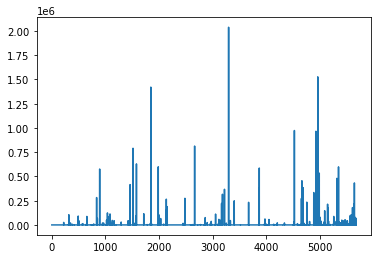

In [75]:
plt.plot(loss.detach().numpy())

In [56]:
vloss_trace, tloss_trace, l1, optimizer, scheduler, Epoch_GLM = train_model(xtr,xte,xtrm,xtem,shift_in_tr,shift_in_te,ytr,yte,params['Nepochs'],l1,optimizer,scheduler,pbar=None)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [77]:
pred = l1(xte, xtem, shift_in_te)
pred_test = pred.detach().numpy()
r2_test = np.array([(np.corrcoef(y_test[:,celln],pred_test[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])

In [78]:
r2_test

array([       nan, 0.05196764,        nan, ..., 0.00019907, 0.00242629,
       0.00045736])